# Ver los resultados desde pandas

Usé `tensorboard dev upload --logdir runs/` para subirlos a https://tensorboard.dev/experiment/pybHa2xKRImxj037vgB2cg/

~~https://tensorboard.dev/experiment/sBAp9q2JQsmCor5XVKzDLg/~~
~~https://tensorboard.dev/experiment/eghgKIKGRXKpKeErDbH7OQ/~~

In [1]:
import tensorboard as tb
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
experiment_id = "pybHa2xKRImxj037vgB2cg"
# experiment_id = "sBAp9q2JQsmCor5XVKzDLg"
#experiment_id = "eghgKIKGRXKpKeErDbH7OQ"
actualizar = False

In [3]:
if actualizar:
    os.remove("tensorboard2pandas.csv")

if not os.path.exists("./tensorboard2pandas.csv"):
    experiment = tb.data.experimental.ExperimentFromDev( experiment_id )
    df = experiment.get_scalars()
    df.to_csv("tensorboard2pandas.csv", index=False)
else :
    df = pd.read_csv("tensorboard2pandas.csv")

In [4]:
df.head()

run         tag  step  \
0  Apr25_16-36-31_ciipme-dm---voxpopuli-speaker-b...  AUC/test/0     1   
1  Apr25_16-36-31_ciipme-dm---voxpopuli-speaker-b...  AUC/test/0     2   
2  Apr25_16-36-31_ciipme-dm---voxpopuli-speaker-b...  AUC/test/0     3   
3  Apr25_16-36-31_ciipme-dm---voxpopuli-speaker-b...  AUC/test/0     4   
4  Apr25_16-36-31_ciipme-dm---voxpopuli-speaker-b...  AUC/test/0     5   

      value  
0  0.541724  
1  0.537614  
2  0.544000  
3  0.546186  
4  0.543600

In [6]:
finales = df.run.str.contains("FINALTHRESH")
df.loc[ finales, "run" ] = df[ finales ].run.str.replace("FINALTHRESH-", "FINALTHRESH_")

In [7]:
df = df[ ~df.run.str.contains("TEST") ]

## Agarro sólo los últimos y lo limpio

In [8]:
df = df[ df.run.str.contains("---") ]

In [9]:
runNames = df.run.str.split("---", expand=True)
runNames.head()

0                                                  1
0  Apr25_16-36-31_ciipme-dm  voxpopuli-speaker-batch_16-[512,512]-SGD-NOWar...
1  Apr25_16-36-31_ciipme-dm  voxpopuli-speaker-batch_16-[512,512]-SGD-NOWar...
2  Apr25_16-36-31_ciipme-dm  voxpopuli-speaker-batch_16-[512,512]-SGD-NOWar...
3  Apr25_16-36-31_ciipme-dm  voxpopuli-speaker-batch_16-[512,512]-SGD-NOWar...
4  Apr25_16-36-31_ciipme-dm  voxpopuli-speaker-batch_16-[512,512]-SGD-NOWar...

### Fecha

In [10]:
runNames[0] = runNames[0].str[0:14]
runNames = runNames.rename( columns={ 0 : "Date" } )

### Meta

In [11]:
runMeta = runNames[1].str.split("-", expand=True)
runMeta = runMeta.rename( columns={
    0 : "initialModel",
    1 : "split",
    2 : "batch_size",
    3 : "classifierType",
    4 : "optimizer",
    5 : "warmup",
    6 : "freeze",
    7 : "dropout",
    8 : "augmentation",
    10 : "learning_rate"
} )

runMeta.batch_size = runMeta.batch_size.str[-2:].astype("int")

runMeta.loc[ runMeta.classifierType == "[512,512]", "classifierType" ] = "Dense_512"
runMeta.loc[ runMeta.classifierType == "[256,256]", "classifierType" ] = "Dense_256"
runMeta.loc[ runMeta.classifierType == "ModelName.Conv1D", "classifierType" ] = "Conv1D"

runMeta.loc[ runMeta.warmup == "NOWarmUp", "warmup" ] = False
runMeta.loc[ runMeta.warmup == "WarmUp_False", "warmup" ] = False
runMeta.loc[ runMeta.warmup == "WarmUp_True", "warmup" ] = True
# runMeta.loc[ runMeta.warmup != "NOWarmUp", "warmup" ] = True

runMeta.loc[ runMeta.freeze == "Freeze_True", "freeze" ] = True
runMeta.loc[ runMeta.freeze == "Freeze_False", "freeze" ] = False

runMeta.loc[ runMeta.dropout == "NObatchNorm", "dropout" ] = runMeta[runMeta.dropout == "NObatchNorm"]["augmentation"]
runMeta.dropout = runMeta.dropout.str[-3:].astype("float")
runMeta.loc[ (runMeta.augmentation == "dropout_0.1") & ( pd.isna(runMeta[9]) ), "augmentation" ] = "0"
runMeta.loc[ (runMeta.augmentation == "dropout_0.1") & ( ~pd.isna(runMeta[9]) ), "augmentation"] = runMeta[9]
runMeta.loc[ runMeta.augmentation.str.contains("aug"), "augmentation" ] = runMeta[ runMeta.augmentation.str.contains("aug") ].augmentation.str[4:]
runMeta.loc[ runMeta.augmentation == "False", "augmentation" ] = "0"

runMeta.loc[ ~pd.isna(runMeta[11]), "learning_rate" ] = runMeta.loc[ ~pd.isna(runMeta[11]), "learning_rate" ] + "-" + runMeta.loc[ ~pd.isna(runMeta[11]), 11 ]
runMeta.loc [ pd.isna(runMeta.learning_rate), "learning_rate" ] = "lr_0.001" 
runMeta.learning_rate = runMeta.learning_rate.str[3:].astype("float")

### Junto

In [12]:
df = pd.concat( (df,runMeta, runNames), axis=1 )
df = df[ df.augmentation != "0.8_noshift_2pitch" ]
df = df[ df.split != "speaker" ]
df = df.drop( columns=["run", 9, 11])
df

tag  step     value     initialModel          split  \
4926    Loss/train/Final     1  0.614119  FINAL_voxpopuli          total   
4927    Loss/train/Final     2  0.505137  FINAL_voxpopuli          total   
4928    Loss/train/Final     1  0.669019  FINAL_voxpopuli          total   
4929    Loss/train/Final     2  0.566623  FINAL_voxpopuli          total   
4930    Loss/train/Final     3  0.504642  FINAL_voxpopuli          total   
...                  ...   ...       ...              ...            ...   
285256      Loss/train/4    36  0.002173        voxpopuli  estratificado   
285257      Loss/train/4    37  0.002146        voxpopuli  estratificado   
285258      Loss/train/4    38  0.161205        voxpopuli  estratificado   
285259      Loss/train/4    39  0.026789        voxpopuli  estratificado   
285260      Loss/train/4    40  0.006387        voxpopuli  estratificado   

        batch_size classifierType optimizer warmup freeze  dropout  \
4926            16          [0,0]      Adam  False  False      0.1   
4927            16          [0,0]      Adam  False  False      0.1   
4928            16          [0,0]      Adam  False  False      0.1   
4929            16          [0,0]      Adam  False  False      0.1   
4930            16          [0,0]      Adam  False  False      0.1   
...            ...            ...       ...    ...    ...      ...   
285256          16         Conv1D      Adam  False  False      0.1   
285257          16         Conv1D      Adam  False  False      0.1   
285258          16         Conv1D      Adam  False  False      0.1   
285259          16         Conv1D      Adam  False  False      0.1   
285260          16         Conv1D      Adam  False  False      0.1   

       augmentation  learning_rate            Date  \
4926              0        0.00100  Aug10_12-19-18   
4927              0        0.00100  Aug10_12-19-18   
4928              0        0.00100  Aug10_12-33-55   
4929              0        0.00100  Aug10_12-33-55   
4930              0        0.00100  Aug10_12-33-55   
...             ...            ...             ...   
285256            0        0.00001  May25_22-01-04   
285257            0        0.00001  May25_22-01-04   
285258            0        0.00001  May25_22-01-04   
285259            0        0.00001  May25_22-01-04   
285260            0        0.00001  May25_22-01-04   

                                                        1  
4926    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...  
4927    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...  
4928    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...  
4929    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...  
4930    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...  
...                                                   ...  
285256  voxpopuli-estratificado-batch_16-ModelName.Con...  
285257  voxpopuli-estratificado-batch_16-ModelName.Con...  
285258  voxpopuli-estratificado-batch_16-ModelName.Con...  
285259  voxpopuli-estratificado-batch_16-ModelName.Con...  
285260  voxpopuli-estratificado-batch_16-ModelName.Con...  

[267981 rows x 15 columns]

In [13]:
tag = df.tag.str.split("/", expand=True)
tag = tag.rename(columns={
    0 : "Metric",
    1 : "Train/Test",
    2 : "Fold"
})
df = pd.concat( (df, tag), axis=1 )
# df = df.drop(columns="tag")
df

tag  step     value     initialModel          split  \
4926    Loss/train/Final     1  0.614119  FINAL_voxpopuli          total   
4927    Loss/train/Final     2  0.505137  FINAL_voxpopuli          total   
4928    Loss/train/Final     1  0.669019  FINAL_voxpopuli          total   
4929    Loss/train/Final     2  0.566623  FINAL_voxpopuli          total   
4930    Loss/train/Final     3  0.504642  FINAL_voxpopuli          total   
...                  ...   ...       ...              ...            ...   
285256      Loss/train/4    36  0.002173        voxpopuli  estratificado   
285257      Loss/train/4    37  0.002146        voxpopuli  estratificado   
285258      Loss/train/4    38  0.161205        voxpopuli  estratificado   
285259      Loss/train/4    39  0.026789        voxpopuli  estratificado   
285260      Loss/train/4    40  0.006387        voxpopuli  estratificado   

        batch_size classifierType optimizer warmup freeze  dropout  \
4926            16          [0,0]      Adam  False  False      0.1   
4927            16          [0,0]      Adam  False  False      0.1   
4928            16          [0,0]      Adam  False  False      0.1   
4929            16          [0,0]      Adam  False  False      0.1   
4930            16          [0,0]      Adam  False  False      0.1   
...            ...            ...       ...    ...    ...      ...   
285256          16         Conv1D      Adam  False  False      0.1   
285257          16         Conv1D      Adam  False  False      0.1   
285258          16         Conv1D      Adam  False  False      0.1   
285259          16         Conv1D      Adam  False  False      0.1   
285260          16         Conv1D      Adam  False  False      0.1   

       augmentation  learning_rate            Date  \
4926              0        0.00100  Aug10_12-19-18   
4927              0        0.00100  Aug10_12-19-18   
4928              0        0.00100  Aug10_12-33-55   
4929              0        0.00100  Aug10_12-33-55   
4930              0        0.00100  Aug10_12-33-55   
...             ...            ...             ...   
285256            0        0.00001  May25_22-01-04   
285257            0        0.00001  May25_22-01-04   
285258            0        0.00001  May25_22-01-04   
285259            0        0.00001  May25_22-01-04   
285260            0        0.00001  May25_22-01-04   

                                                        1 Metric Train/Test  \
4926    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...   Loss      train   
4927    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...   Loss      train   
4928    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...   Loss      train   
4929    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...   Loss      train   
4930    FINAL_voxpopuli-total-batch_16-[0,0]-Adam-Warm...   Loss      train   
...                                                   ...    ...        ...   
285256  voxpopuli-estratificado-batch_16-ModelName.Con...   Loss      train   
285257  voxpopuli-estratificado-batch_16-ModelName.Con...   Loss      train   
285258  voxpopuli-estratificado-batch_16-ModelName.Con...   Loss      train   
285259  voxpopuli-estratificado-batch_16-ModelName.Con...   Loss      train   
285260  voxpopuli-estratificado-batch_16-ModelName.Con...   Loss      train   

         Fold  
4926    Final  
4927    Final  
4928    Final  
4929    Final  
4930    Final  
...       ...  
285256      4  
285257      4  
285258      4  
285259      4  
285260      4  

[267981 rows x 18 columns]

### Modelos

In [14]:
modelos = df.groupby(["initialModel","split","batch_size", "classifierType", "optimizer", "warmup", "freeze", "dropout", "augmentation", "learning_rate"], as_index=False).max()
modelos = modelos[["initialModel","split","batch_size", "classifierType", "optimizer", "warmup", "freeze", "dropout", "augmentation", "learning_rate", "step"]]
# modelos.sort_values(["split", "classifierType", "freeze", "dropout", "augmentation"])
modelos

initialModel          split  batch_size classifierType optimizer  \
0   FINALTHRESH_voxpopuli  estratificado          16         Conv1D      Adam   
1         FINAL_voxpopuli          total          16         Conv1D      Adam   
2         FINAL_voxpopuli          total          16          [0,0]      Adam   
3                baseline  estratificado          64         Conv1D      Adam   
4                baseline  estratificado          64         Conv1D      Adam   
5                baseline  estratificado          64         Conv1D      Adam   
6                baseline  estratificado          64         Conv1D      Adam   
7                baseline  estratificado          64         Conv1D      Adam   
8                baseline  estratificado          64         Conv1D      Adam   
9                baseline  estratificado          64         Conv1D      Adam   
10               baseline  estratificado          64         Conv1D      Adam   
11               baseline  estratificado          64         Conv1D      Adam   
12               baseline         family          64         Conv1D      Adam   
13               baseline         family          64         Conv1D      Adam   
14               baseline         family          64         Conv1D      Adam   
15               baseline         family          64         Conv1D      Adam   
16               baseline         family          64         Conv1D      Adam   
17               baseline         family          64         Conv1D      Adam   
18               baseline         family          64         Conv1D      Adam   
19               baseline         family          64         Conv1D      Adam   
20               baseline         family          64         Conv1D      Adam   
21              voxpopuli  estratificado          16         Conv1D      Adam   
22              voxpopuli  estratificado          16         Conv1D      Adam   
23              voxpopuli  estratificado          16         Conv1D      Adam   
24              voxpopuli  estratificado          16         Conv1D      Adam   
25              voxpopuli  estratificado          16         Conv1D      Adam   
26              voxpopuli  estratificado          16         Conv1D       SGD   
27              voxpopuli  estratificado          64         Conv1D      Adam   
28              voxpopuli  estratificado          64         Conv1D      Adam   
29              voxpopuli  estratificado          64         Conv1D      Adam   
30              voxpopuli  estratificado          64         Conv1D      Adam   
31              voxpopuli  estratificado          64         Conv1D      Adam   
32              voxpopuli  estratificado          64         Conv1D       SGD   
33              voxpopuli         family          16         Conv1D      Adam   
34              voxpopuli         family          16         Conv1D      Adam   
35              voxpopuli         family          16         Conv1D      Adam   
36              voxpopuli         family          16         Conv1D      Adam   
37              voxpopuli         family          16         Conv1D      Adam   
38              voxpopuli         family          16         Conv1D      Adam   
39              voxpopuli         family          16         Conv1D      Adam   
40              voxpopuli         family          16         Conv1D      Adam   
41              voxpopuli         family          16         Conv1D      Adam   
42              voxpopuli         family          16         Conv1D      Adam   
43              voxpopuli         family          16         Conv1D      Adam   
44              voxpopuli         family          16         Conv1D      Adam   
45              voxpopuli         family          16         Conv1D      Adam   
46              voxpopuli         family          16         Conv1D       SGD   
47              voxpopuli         family          16         Conv1D       SGD   
48              voxpopuli         family    

In [15]:
df["ID"] = -1
for i, m in modelos.iterrows():
    df.loc[
        ( df.initialModel == m.initialModel ) &
        ( df.split == m.split ) &
        ( df.batch_size == m.batch_size ) &
        ( df.classifierType == m.classifierType ) &
        ( df.optimizer == m.optimizer ) &
        ( df.warmup == m.warmup ) &
        ( df.freeze == m.freeze ) &
        ( df.dropout == m.dropout ) &
        ( df.augmentation == m.augmentation ) &
        ( df.learning_rate == m.learning_rate ) ,
        "ID"
    ] = i

# df["ID"] = df.ID.astype("string")

#### Modelos que me interesan

##### Final

In [16]:
modelos[ (modelos.initialModel == "FINAL_voxpopuli") ]

initialModel  split  batch_size classifierType optimizer  warmup  \
1  FINAL_voxpopuli  total          16         Conv1D      Adam   False   
2  FINAL_voxpopuli  total          16          [0,0]      Adam   False   

   freeze  dropout augmentation  learning_rate  step  
1   False      0.1            0          0.001    15  
2   False      0.1            0          0.001    40

##### Baseline

* Estratificado

In [17]:
modelos[ (modelos.initialModel == "baseline") &
         (modelos.split == "estratificado") ]
         
# en este caso 6 es el mejor, mejora un poco la EER y principalmente achica el desvio
#grafico: 2 vs 6

initialModel          split  batch_size classifierType optimizer  warmup  \
3      baseline  estratificado          64         Conv1D      Adam   False   
4      baseline  estratificado          64         Conv1D      Adam   False   
5      baseline  estratificado          64         Conv1D      Adam   False   
6      baseline  estratificado          64         Conv1D      Adam   False   
7      baseline  estratificado          64         Conv1D      Adam   False   
8      baseline  estratificado          64         Conv1D      Adam   False   
9      baseline  estratificado          64         Conv1D      Adam   False   
10     baseline  estratificado          64         Conv1D      Adam   False   
11     baseline  estratificado          64         Conv1D      Adam   False   

    freeze  dropout augmentation  learning_rate  step  
3    False      0.1            0       0.000001   300  
4    False      0.1            0       0.000010   300  
5    False      0.1            0       0.000100   300  
6    False      0.1            0       0.001000   150  
7    False      0.1            0       0.010000   300  
8    False      0.1          0.1       0.000100   300  
9    False      0.1          0.2       0.000100   300  
10   False      0.1          0.4       0.000100   300  
11   False      0.1          0.6       0.000100   300

* Family

In [18]:
modelos[ (modelos.initialModel == "baseline") &
         (modelos.split == "family") ]
         
# en este caso el augmentation no sirve para nada, solo empeora el modelo. por qué ?

initialModel   split  batch_size classifierType optimizer  warmup  freeze  \
12     baseline  family          64         Conv1D      Adam   False   False   
13     baseline  family          64         Conv1D      Adam   False   False   
14     baseline  family          64         Conv1D      Adam   False   False   
15     baseline  family          64         Conv1D      Adam   False   False   
16     baseline  family          64         Conv1D      Adam   False   False   
17     baseline  family          64         Conv1D      Adam   False   False   
18     baseline  family          64         Conv1D      Adam   False   False   
19     baseline  family          64         Conv1D      Adam   False   False   
20     baseline  family          64         Conv1D      Adam   False   False   

    dropout augmentation  learning_rate  step  
12      0.1            0       0.000001   300  
13      0.1            0       0.000010   300  
14      0.1            0       0.000100   300  
15      0.1            0       0.001000   300  
16      0.1            0       0.010000   300  
17      0.1          0.1       0.000100   300  
18      0.1          0.2       0.000100   300  
19      0.1          0.4       0.000100   300  
20      0.1          0.6       0.000100   300

##### VoxPopuli

* Estratificado

In [19]:
modelos[ (modelos.initialModel == "voxpopuli") &
         (modelos.split == "estratificado") &
         (modelos.optimizer == "Adam")]

#  26 el mejor learning rate para freeze = true
# el augmentation no sirve

initialModel          split  batch_size classifierType optimizer  warmup  \
21    voxpopuli  estratificado          16         Conv1D      Adam   False   
22    voxpopuli  estratificado          16         Conv1D      Adam   False   
23    voxpopuli  estratificado          16         Conv1D      Adam   False   
24    voxpopuli  estratificado          16         Conv1D      Adam   False   
25    voxpopuli  estratificado          16         Conv1D      Adam   False   
27    voxpopuli  estratificado          64         Conv1D      Adam   False   
28    voxpopuli  estratificado          64         Conv1D      Adam   False   
29    voxpopuli  estratificado          64         Conv1D      Adam   False   
30    voxpopuli  estratificado          64         Conv1D      Adam   False   
31    voxpopuli  estratificado          64         Conv1D      Adam   False   

    freeze  dropout augmentation  learning_rate  step  
21   False      0.1            0       0.000010    40  
22   False      0.1          0.1       0.000010    40  
23   False      0.1          0.2       0.000010    40  
24   False      0.1          0.4       0.000010    40  
25   False      0.1          0.6       0.000010    40  
27    True      0.1            0       0.000001   100  
28    True      0.1            0       0.000010   100  
29    True      0.1            0       0.000100   100  
30    True      0.1            0       0.001000   100  
31    True      0.1            0       0.010000   100

In [20]:
df[ df.ID == 18 ]["Date"].unique()

array(['Jun13_22-58-46'], dtype=object)

* Family
* * Freezed

In [21]:
modelos[ (modelos.initialModel == "voxpopuli") &
         (modelos.split == "family") &
         (modelos.optimizer == "Adam") & 
         (modelos.freeze == True)]
         
#47 vs 48 no esta tan claro quien gana
#aug empeora, lo que parecería pasar es que en algunos casos mejora y en otros empeora entonces sube mucho el desvio


initialModel   split  batch_size classifierType optimizer  warmup  freeze  \
41    voxpopuli  family          16         Conv1D      Adam   False    True   
42    voxpopuli  family          16         Conv1D      Adam   False    True   
43    voxpopuli  family          16         Conv1D      Adam   False    True   
44    voxpopuli  family          16         Conv1D      Adam   False    True   
50    voxpopuli  family          64         Conv1D      Adam   False    True   
51    voxpopuli  family          64         Conv1D      Adam   False    True   
52    voxpopuli  family          64         Conv1D      Adam   False    True   

    dropout augmentation  learning_rate  step  
41      0.1          0.1        0.00001    40  
42      0.1          0.2        0.00001    40  
43      0.1          0.4        0.00001    40  
44      0.1          0.6        0.00001    40  
50      0.1            0        0.00001    40  
51      0.1            0        0.00010   120  
52      0.1            0        0.00100    40

* * Fine tuned

In [22]:
modelos[ (modelos.initialModel == "voxpopuli") &
         (modelos.split == "family") &
         (modelos.optimizer == "Adam") & 
         (modelos.freeze == False) & 
         (modelos.learning_rate == 0.00001)]

# Augmentation no sirve

initialModel   split  batch_size classifierType optimizer  warmup  freeze  \
34    voxpopuli  family          16         Conv1D      Adam   False   False   
37    voxpopuli  family          16         Conv1D      Adam   False   False   
38    voxpopuli  family          16         Conv1D      Adam   False   False   
39    voxpopuli  family          16         Conv1D      Adam   False   False   
40    voxpopuli  family          16         Conv1D      Adam   False   False   

    dropout augmentation  learning_rate  step  
34      0.1            0        0.00001    40  
37      0.1          0.1        0.00001    40  
38      0.1          0.2        0.00001    40  
39      0.1          0.4        0.00001    40  
40      0.1          0.6        0.00001    40

XSLR

Acá no hubo búsqueda de hiperparámetros

In [23]:
modelos[ (modelos.initialModel == "xlsr") ] #&
#          (modelos.split == "estratificado") &
#          (modelos.optimizer == "Adam")]

#  26 el mejor learning rate para freeze = true
# el augmentation no sirve

initialModel          split  batch_size classifierType optimizer  warmup  \
53         xlsr  estratificado          16         Conv1D      Adam   False   
54         xlsr  estratificado          16         Conv1D      Adam   False   
55         xlsr  estratificado          16         Conv1D      Adam   False   
56         xlsr         family          16         Conv1D      Adam   False   
57         xlsr         family          16         Conv1D      Adam   False   
58         xlsr         family          64         Conv1D      Adam   False   

    freeze  dropout augmentation  learning_rate  step  
53   False      0.1            0        0.00001   100  
54    True      0.1            0        0.00001    40  
55    True      0.1            0        0.00010    40  
56   False      0.1            0        0.00001   100  
57    True      0.1            0        0.00010   100  
58    True      0.1            0        0.00010   100

## Me fijo cantidades por familia

In [51]:
import sys
sys.path.append('../')
import Datasets

datasetName, dfAudio, dfMetadata = Datasets.getQOMvsSPA( Datasets.DATASET_RAW, split="family", augment=False )

TypeError: getQOMvsSPA() got an unexpected keyword argument 'augment'

In [ ]:
dfMetadata.head()

Text(0.5, 1.0, 'Tiempos por familia')

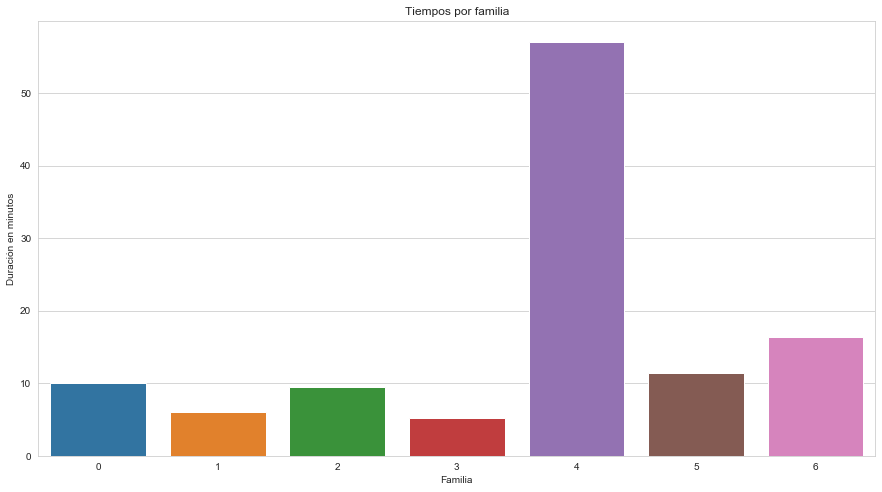

In [128]:
dfViz = dfMetadata.groupby("kfold", as_index=False).sum()
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
p = sns.barplot(x="kfold",y=dfViz["durations"]/60, data=dfViz)
p.set_xlabel("Familia")
p.set_ylabel("Duración en minutos")
plt.title("Tiempos por familia")


Text(0.5, 1.0, 'Tiempos por lengua')

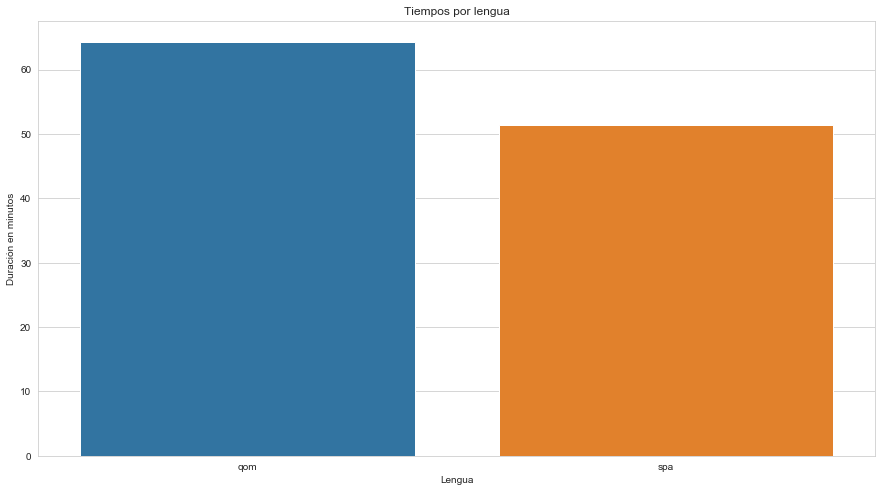

In [127]:
dfViz = dfMetadata.groupby("lang", as_index=False).sum()
plt.figure(figsize=(15,8))
p = sns.barplot(x="lang",y=dfViz["durations"]/60, data=dfViz)
p.set_xlabel("Lengua")
p.set_ylabel("Duración en minutos")
plt.title("Tiempos por lengua")

In [137]:
# dfViz = dfMetadata.groupby("lang", as_index=False).sum()
# dfViz["durations_min"] = dfViz["durations"]/60
# plt.figure(figsize=(15,8))
# # p = sns.barplot(x="lang",y=dfViz["durations"]/60, data=dfViz, stacked=True)
# p = dfViz.plot(kind="bar",color="lang",y="durations_min", stacked=True)
# p.set_xlabel("Lengua")
# p.set_ylabel("Duración en minutos")
# plt.title("Tiempos por lengua")

Text(0.5, 1.0, 'Tiempos por lengua y tipo de hablante')

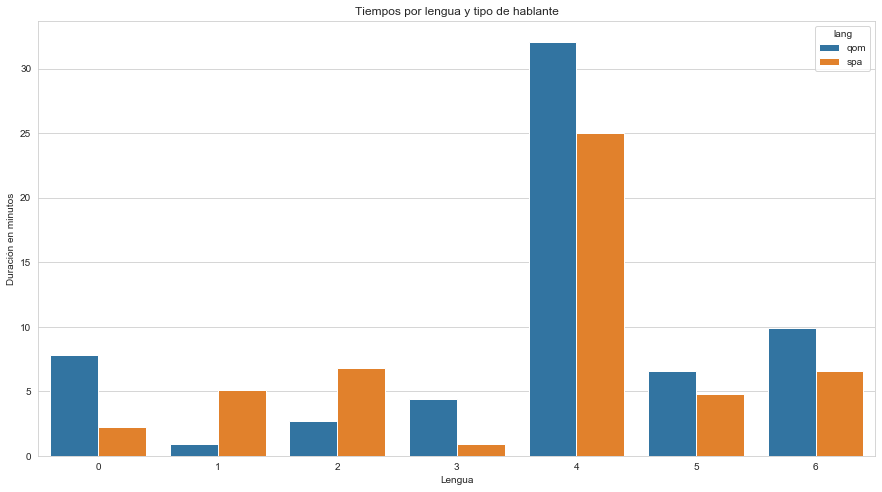

In [125]:
dfViz = dfMetadata.groupby(["kfold","lang"], as_index=False).sum()
dfViz
plt.figure(figsize=(15,8))
p = sns.barplot(x="kfold",y=dfViz["durations"]/60, hue="lang", data=dfViz)
p.set_xlabel("Lengua")
p.set_ylabel("Duración en minutos")
plt.title("Tiempos por lengua y tipo de hablante")

In [99]:
dfMetadata.durations.sum()/60

115.71295663501512

## Resultados

Para estratificado:

In [28]:
ID = 58
metric = "EER"
trainTest = "test"

maxStep = df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]["step"].max()
dfResult = df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) & ( df["step"] == maxStep ) ]["value"]

display("Media", dfResult.mean())
display("Mediana", dfResult.median())
display("Desvio", dfResult.std())
display("Minimo", dfResult.min())
display("Máximo", dfResult.max())



maxStep = 20
print(f"\nStep: {maxStep}")
dfResult = df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) & ( df["step"] == maxStep ) ]["value"]

display("Media", dfResult.mean())
display("Mediana", dfResult.median())
display("Desvio", dfResult.std())
display("Minimo", dfResult.min())
display("Máximo", dfResult.max())

'Media'

0.46987587213516235

'Mediana'

0.4631560742855072

'Desvio'

0.07672165834621025

'Minimo'

0.3697367012500763

'Máximo'

0.5737906694412231


Step: 20


'Media'

0.45430842467716764

'Mediana'

0.4471179246902466

'Desvio'

0.06795531072682531

'Minimo'

0.36386555433273315

'Máximo'

0.5739924907684326

In [63]:
ID = 55
metric = "EER"
trainTest = "test"


mejorMedia = df[ (df.ID == ID) & 
              (df.Metric == metric) & 
              (df["Train/Test"] == trainTest) & (df.Fold != "4") ].groupby("step").mean()["value"]

print(mejorMedia.idxmin())
print(mejorMedia.min())

18
0.27660537511110306


In [64]:
ID = 55
metric = "EER"
trainTest = "test"

maxStep = df[ (df.ID == ID) & 
              (df.Metric == metric) & 
              (df["Train/Test"] == trainTest) &
              (df.Fold != "4") ]["step"].max()

dfResult = df[ (df.ID == ID) & 
               (df.Metric == metric) & 
               (df["Train/Test"] == trainTest) & 
               (df["step"] == maxStep) &
               (df.Fold != "4") ]["value"]

display("Media", dfResult.mean())
display("Mediana", dfResult.median())
display("Desvio", dfResult.std())
display("Minimo", dfResult.min())
display("Máximo", dfResult.max())

maxStep = 18
print(f"\nStep: {maxStep}")

dfResult = df[ (df.ID == ID) & 
               (df.Metric == metric) & 
               (df["Train/Test"] == trainTest) & 
               (df["step"] == maxStep) &
               (df.Fold != "4") ]["value"]

display("Media", dfResult.mean())
display("Mediana", dfResult.median())
display("Desvio", dfResult.std())
display("Minimo", dfResult.min())
display("Máximo", dfResult.max())

'Media'

0.2909582890570164

'Mediana'

0.28878747671842575

'Desvio'

0.05325120857683995

'Minimo'

0.24386289715766907

'Máximo'

0.3423953056335449


Step: 18


'Media'

0.27660537511110306

'Mediana'

0.2744186669588089

'Desvio'

0.02346220834497762

'Minimo'

0.25028735399246216

'Máximo'

0.3072968125343323

In [75]:
df.Metric.unique()

array(['Loss', 'AUC', 'EER', 'EER_threshold', 'lr'], dtype=object)

In [78]:
df.columns

Index([           'tag',           'step',          'value',   'initialModel',
                'split',     'batch_size', 'classifierType',      'optimizer',
               'warmup',         'freeze',        'dropout',   'augmentation',
        'learning_rate',           'Date',                1,         'Metric',
           'Train/Test',           'Fold',             'ID'],
      dtype='object')

In [34]:
df[ (df.ID == ID) & 
              (df.Metric == metric) & 
              (df["Train/Test"] == trainTest) & 
              (df.Fold != 2) &
              ( df["step"] == maxStep ) ]["Fold"]

5800    0
5840    1
5880    2
5920    3
5960    4
Name: Fold, dtype: object

In [47]:
ID = 0
metric = "EER_threshold"
trainTest = "test"

maxStep = 9
print(f"\nStep: {maxStep}")
dfResult = df[ (df.ID == ID) & 
              (df.Metric == metric) & 
              (df["Train/Test"] == trainTest) & 
#               (df.Fold != "3") & (df.Fold != "2") &
              ( df["step"] == maxStep ) ]["value"]

display("Media", dfResult.mean())
display("Mediana", dfResult.median())
display("Desvio", dfResult.std())
display("Minimo", dfResult.min())
display("Máximo", dfResult.max())


Step: 9


'Media'

0.6550439834594727

'Mediana'

0.6457192897796631

'Desvio'

0.25259848255222794

'Minimo'

0.3032261729240417

'Máximo'

0.9019151329994202

Para family:

In [295]:
ID = 68
metric = "EER"
trainTest = "test"

maxStep = df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]["step"].max()
dfResult = df[ (df.ID == ID) 
               & (df.Metric == metric) 
               & (df["Train/Test"] == trainTest) 
               & (df["step"] == maxStep) 
               & (df["Fold"] != "4")]["value"]

display("Media", dfResult.mean())
display("Desvio", dfResult.std())
display("Minimo", dfResult.min())
display("Máximo", dfResult.max())
display("Diff", dfResult.max()-dfResult.min() )

'Media'

0.470935861269633

'Desvio'

0.044209629353461365

'Minimo'

0.4061400592327118

'Máximo'

0.5295518040657043

'Diff'

0.12341174483299255

In [302]:
ID = 50
metric = "EER"
trainTest = "test"

maxStep = df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]["step"].max()
dfResult = df[ (df.ID == ID) 
               & (df.Metric == metric) 
               & (df["Train/Test"] == trainTest) 
               & (df["step"] == maxStep) 
               & (df["Fold"] != "4")]["value"]

display("Media", dfResult.mean())
display("Desvio", dfResult.std())
display("Minimo", dfResult.min())
display("Máximo", dfResult.max())
display("Diff", dfResult.max()-dfResult.min() )

'Media'

0.36661336819330853

'Desvio'

0.07039306758049876

'Minimo'

0.28626149892807007

'Máximo'

0.47455400228500366

'Diff'

0.1882925033569336

## Gráficos

### 1 modelo

Text(0.5, 1.0, 'Loss / test for model #0')

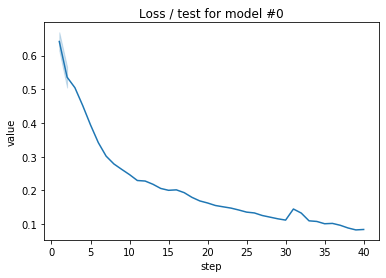

In [19]:
#Final
ID = 0
metric = "Loss"
trainTest = "test"

sns.lineplot( x="step", y="value", data=df[ (df.ID == ID) & (df.Metric == metric) ]  )
plt.title(f"{metric} / {trainTest} for model #{ID}")

Text(0.5, 1.0, 'Loss / test for model #20')

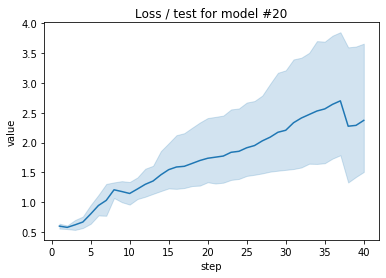

In [23]:
ID = 20
metric = "Loss"
trainTest = "test"

sns.lineplot( x="step", y="value", data=df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]  )
plt.title(f"{metric} / {trainTest} for model #{ID}")

Text(0.5, 1.0, 'EER / test for model #51')

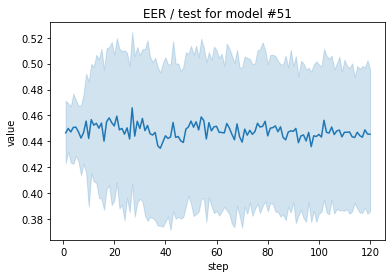

In [55]:
ID = 51
metric = "EER"
trainTest = "test"

sns.lineplot( x="step", y="value", data=df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]  )
plt.title(f"{metric} / {trainTest} for model #{ID}")

Text(0.5, 1.0, 'EER / test for model #55')

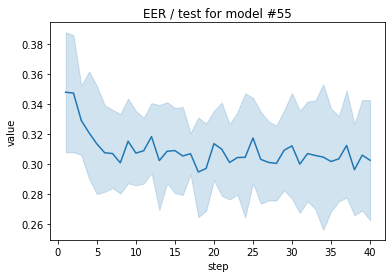

In [50]:
ID = 55
metric = "EER"
trainTest = "test"

sns.lineplot( x="step", y="value", data=df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]  )
plt.title(f"{metric} / {trainTest} for model #{ID}")

Text(0.5, 1.0, 'EER_threshold / test for model #0')

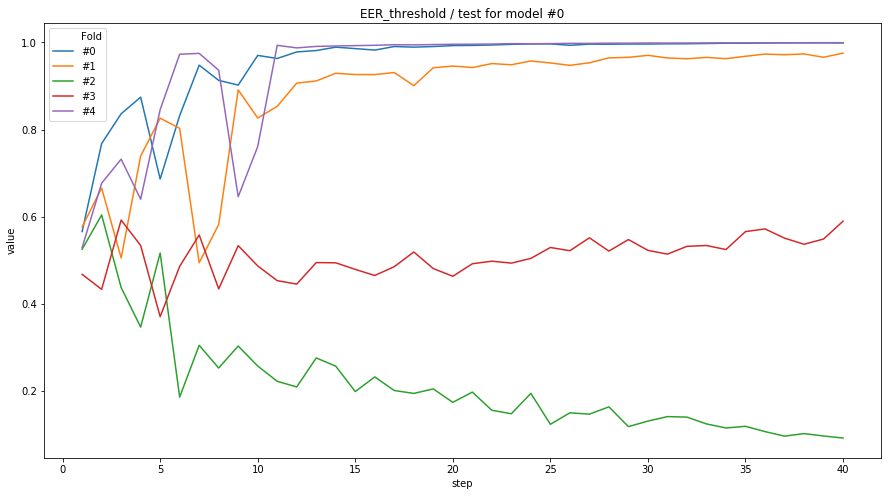

In [28]:
ID = 0
metric = "EER_threshold"
trainTest = "test"
plt.figure(figsize=(15,8))

dfViz = df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]

sns.lineplot( x="step", y="value", hue="#" + dfViz.Fold , data=dfViz)
plt.title(f"{metric} / {trainTest} for model #{ID}")

Text(0.5, 1.0, 'EER / test for model #55')

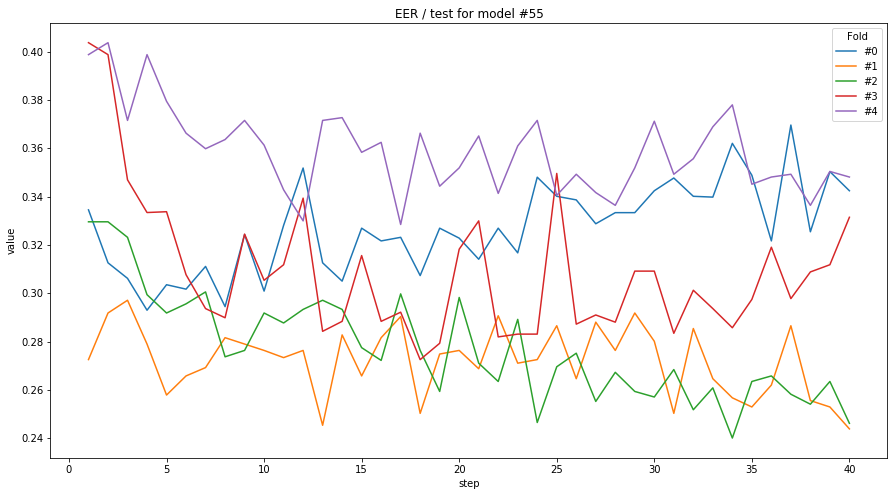

In [49]:
ID = 55
metric = "EER"
trainTest = "test"
plt.figure(figsize=(15,8))

dfViz = df[ (df.ID == ID) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]

sns.lineplot( x="step", y="value", hue="#" + dfViz.Fold , data=dfViz)
plt.title(f"{metric} / {trainTest} for model #{ID}")

### Varios modelos

Text(0.5, 1.0, 'EER / test for model #[47, 39]')

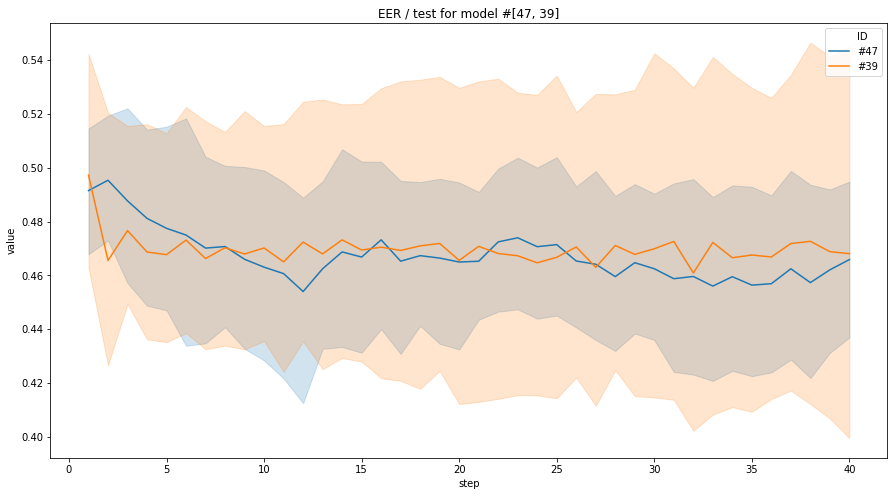

In [298]:
ID = [47,39]
metric = "EER"
trainTest = "test"

dfViz = df[ (df.ID.isin(ID)) & 
            (df.Metric == metric) & 
            (df["Train/Test"] == trainTest)
           
            #& (df.Fold != "4") #guarda aca 
          ]

plt.figure(figsize=(15,8))
sns.lineplot( x="step", y="value", hue="#" + dfViz["ID"].astype("str"), data=dfViz  )
plt.title(f"{metric} / {trainTest} for model #{ID}")

Text(0.5, 1.0, 'Loss / test for model #[2, 10]')

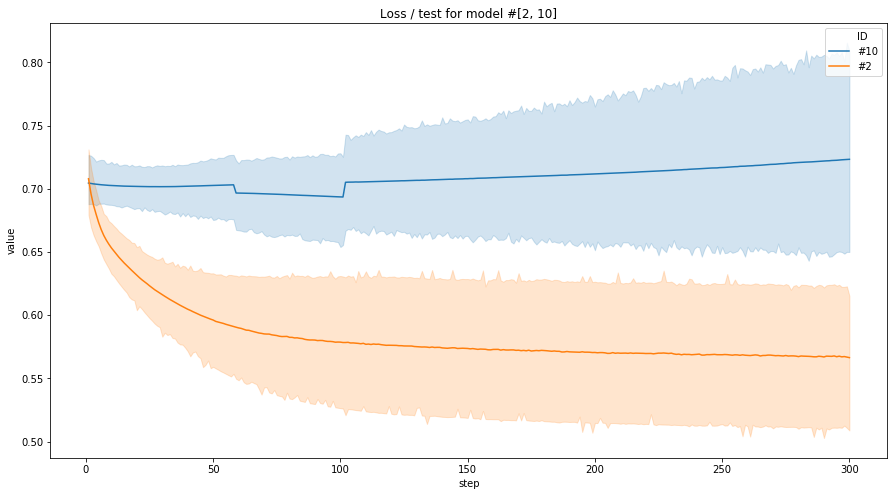

In [21]:
ID = [2,10]
metric = "Loss"
trainTest = "test"

dfViz = df[ (df.ID.isin(ID)) & 
            (df.Metric == metric) & 
            (df["Train/Test"] == trainTest)
          ]

plt.figure(figsize=(15,8))
sns.lineplot( x="step", y="value", hue="#" + dfViz["ID"].astype("str"), data=dfViz  )
plt.title(f"{metric} / {trainTest} for model #{ID}")

### En columnas

<Figure size 1080x576 with 0 Axes>

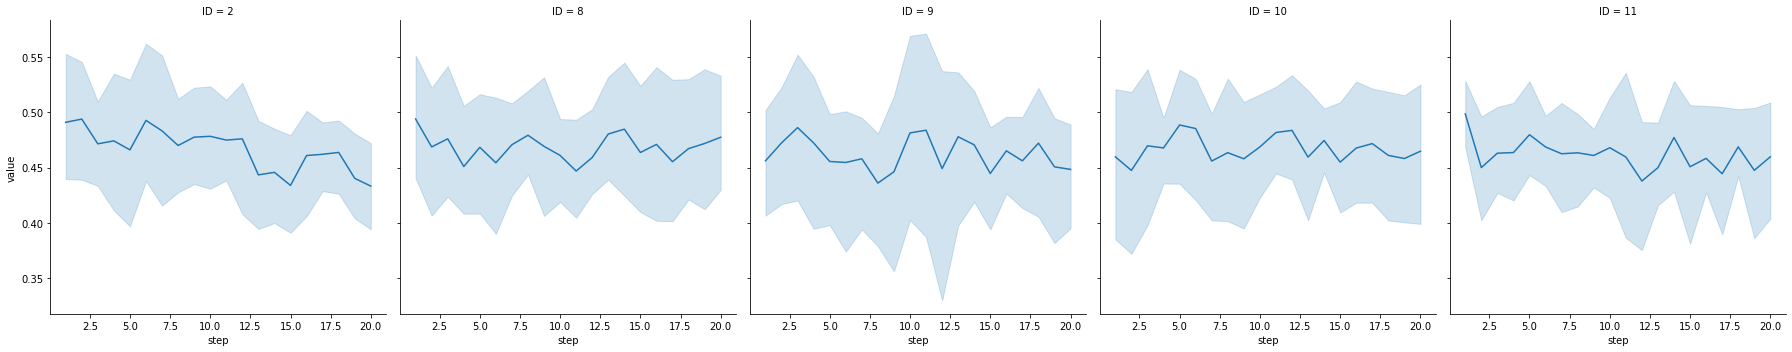

In [71]:
ID = [2, 8, 9, 10, 11]
metric = "EER"
trainTest = "test"

dfViz = df[ (df.ID.isin(ID)) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]

plt.figure(figsize=(15,8))
sns.relplot( x="step", y="value", col="ID", kind="line", data=dfViz  )
# plt.title(f"{metric} / {trainTest} for model #{ID}")

<Figure size 1080x576 with 0 Axes>

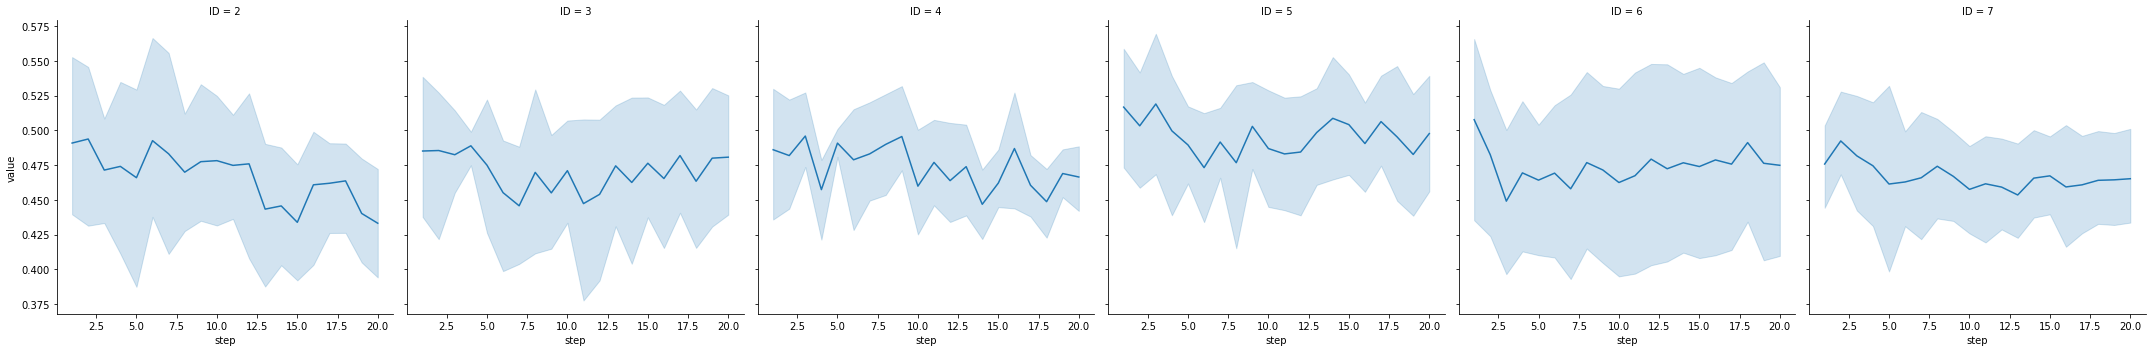

In [49]:
ID = [2, 3, 4, 5, 6, 7]
metric = "EER"
trainTest = "test"

plt.figure(figsize=(15,8))
sns.relplot( x="step", y="value", col="ID", kind="line", data=df[ (df.ID.isin(ID)) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]  )
# plt.title(f"{metric} / {trainTest} for model #{ID}")

<Figure size 1080x576 with 0 Axes>

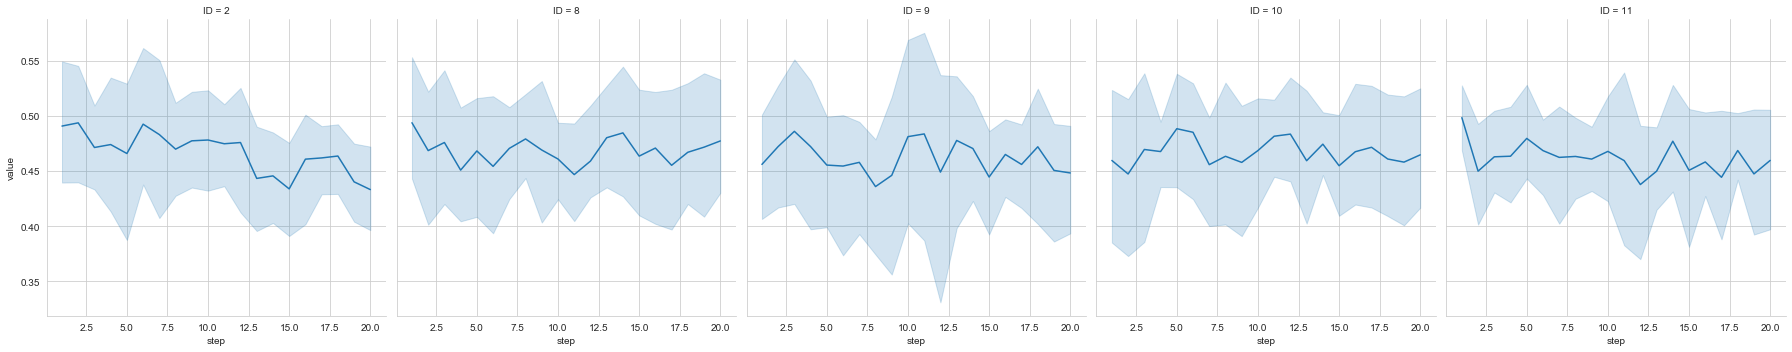

In [138]:
#### ID = [2, 12]
metric = "EER"
trainTest = "test"

plt.figure(figsize=(15,8))
sns.relplot( x="step", y="value", col="ID", kind="line", data=df[ (df.ID.isin(ID)) & (df.Metric == metric) & (df["Train/Test"] == trainTest) ]  )
# plt.title(f"{metric} / {trainTest} for model #{ID}")